# PyBATS

> PyBATS is a package for Bayesian time series modeling and forecasting. It is designed to be flexible, offering many options to customize the model form, prior, and forecast period. The focus of the package is the class Dynamic Generalized Linear Model ('dglm'). The supported DGLMs are Poisson, Bernoulli, Normal (a DLM), and Binomial. These models are based upon *Bayesian Forecasting and Dynamic Models*, by West and Harrison (1997).

## Install

PyBATS is hosted on _PyPI_ and can be installed with pip:

    $ pip install pybats

The most recent development version is hosted on [GitHub](https://github.com/lavinei/pybats). You can download and install from there:

```
$ git clone git@github.com:lavinei/pybats.git pybats
$ cd pybats
$ sudo python setup.py install
```

## Quick Start

This provides the most basic example of Bayesian time series analysis using PyBATS. We'll use a public dataset of the sales of a dietary weight control product, along with the advertising spend. These are integer valued counts, which we model with a Poisson Dynamic Generalized Linear Model (DGLM).

First we load in the data, and take a quick look at the first couples of entries:

In [ ]:
import numpy as np

from pybats_nbdev.shared import load_sales_example
from pybats_nbdev.analysis import *
from pybats_nbdev.point_forecast import *
from pybats_nbdev.plot import *

# Load example sales and advertising data. Source: Abraham & Ledolter (1983)
data = load_sales_example()             
data.head(3)

,Sales,Advertising
1,15,12.0
2,16,20.5
3,18,21.0


Second, we extract the outcome (_Y_) and covariate (_X_) from this dataset. We'll set the forecast horizon _k=1_ for this example. We could look at multiple forecast horizons by setting k to a larger value. Then the 'analysis' function will automatically perform marginal forecasts across horizons _1:k_.

Finally, we set the start and end time for forecasting. In this case we specify the start and end date with integers, because there are no dates associated with this dataset.

In [ ]:
Y = data['Sales'].values
X = data['Advertising'].values

k = 1                                               # Forecast 1 step ahead
forecast_start = 15                                 # Start forecast at time step 15
forecast_end = 35                                   # End forecast at time step 35 (final time step)

We use the _analysis_ function as a helper to a) define the model b) Run sequential updating (forward filtering) and c) forecasting. By default, it will return samples from the forecast distribution as well as the model after the final observation.

In [ ]:
mod, samples = analysis(Y, X, family="poisson",
forecast_start=forecast_start,      # First time step to forecast on
forecast_end=forecast_end,          # Final time step to forecast on
k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
prior_length=6,                     # How many data point to use in defining prior
rho=.5,                             # Random effect extension, increases variance of Poisson DGLM (see Berry and West, 2019)
deltrend=0.95,                      # Discount factor on the trend component (intercept)
delregn=0.95                        # Discount factor on the regression component
)

beginning forecasting


The model has the posterior mean and variance of the state vector stored as ```mod.a``` and ```mod.C``` respectively.  In this example, we are purely interested in the forecasts. We plot the sales, median forecast, and 95\% credible interval.

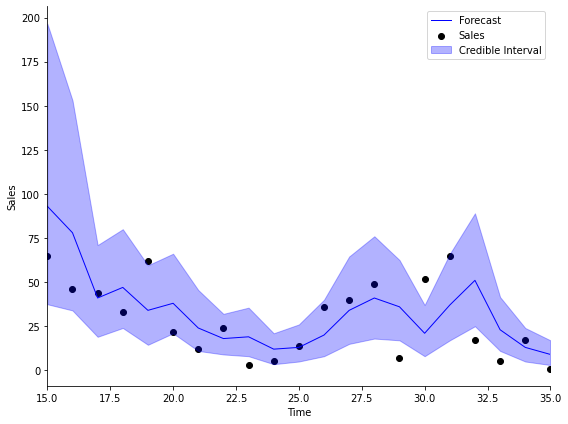

In [ ]:
import matplotlib.pyplot as plt

# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y[forecast_start:forecast_end + k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+1, dtype='int'))
ax = ax_style(ax, ylabel='Sales', xlabel='Time', xlim=[forecast_start, forecast_end],
              legend=['Forecast', 'Sales', 'Credible Interval'])

## Model Components

All models in PyBATS are based on DGLMs, who are well described by their name:

1. **Dynamic**: The coefficients are *changing* over time
2. **Generalized**: We can choose the distribution of the observations (Normal, Poisson, Bernoulli, or Binomial)
3. **Linear**: Forecasts are made by a linear combination of coefficients multiplied by predictors

The coefficients in a DGLM are all stored in the state vector, $\theta_t$. The state vector is defined by a set of different components, which are defined up front by the modeler. 

### Trend Component

PyBATS supports $0$, $1$, and $2$ trend terms in a DGLM. $1$ trend term is simply an intercept in the model. If there are $2$ trend terms, then the model contains and intercept *and* a local slope, which increments (is added to) the intercept at each time step. Because all coefficients are dynamic, both the intercept and local slope will change over time.

The default setting is to only have an intercept term, which we can see from the model defined in the example above:

In [ ]:
mod.ntrend

1

We can access the mean $E\left[ \theta_t \right]$ and variance $V\left[ \theta_t \right]$ of the state vector by the attribute names **a** and **R**:

In [ ]:
mod.a[mod.itrend], mod.R.diagonal()[mod.itrend]

(array([[0.63431615]]), array([0.128739]))

So the intercept term has a mean of $0.63$ and a variance of $0.13$.

To add in a local slope, we can re-run the analysis from above, while specifying that `ntrend=2`.

In [ ]:
mod, samples = analysis(Y, X, family="poisson",
ntrend=2,                           # Use an intercept and local slope
forecast_start=forecast_start,      # First time step to forecast on
forecast_end=forecast_end,          # Final time step to forecast on
k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
prior_length=6,                     # How many data point to use in defining prior
rho=.5,                             # Random effect extension, increases variance of Poisson DGLM (see Berry and West, 2019)
deltrend=0.95,                      # Discount factor on the trend component (intercept)
delregn=0.95                        # Discount factor on the regression component
)

beginning forecasting


In [ ]:
mod.ntrend

2

We can plot the forecasts with this new model, and see that the results are quite similar!

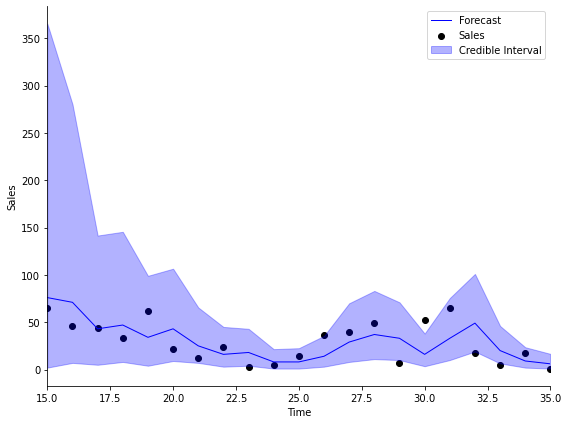

In [ ]:
# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y[forecast_start:forecast_end + k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+1, dtype='int'))
ax = ax_style(ax, ylabel='Sales', xlabel='Time', xlim=[forecast_start, forecast_end],
              legend=['Forecast', 'Sales', 'Credible Interval'])

### Regression Component

The regression component is the most commonly recognized part of a linear model, where any known predictors are used. In this example, the advertising budget is our known predictor, which is stored in the $X$ array. When there are multiple predictors, each one is stored in a column of $X$.

In [ ]:
X[:5]

array([12. , 20.5, 21. , 15.5, 15.3])

The `analysis` function automatically detected that $X$ only had $1$ column, and so it defined the model to have the correct number of regression components.

In [ ]:
mod.nregn

1

To under the impact of advertising on sales, we can look at the regression coefficients:

In [ ]:
mod.a[mod.iregn], mod.R.diagonal()[mod.iregn]

(array([[0.09542123]]), array([0.00048791]))

The coefficient mean is $0.95$, with a very small variance. Because the mean of the coefficient is positive, we can interpret this coefficient as saying that an increase in advertising will increase our forecast of sales. Good, that makes sense! Of course, precise interpretation is tricky - later on we will provide the exact formula for a Poisson DGLM, so we can see exactly how the coefficients relate to the outcome.

To quantify the uncertainty of the parameter, many people like to use the standard deviation (or standard error) of the coefficient, which is simply the square root of the variance. A good rule of thumb to get a pseudo-confidence interval is to add $\pm$ 2*sd(coefficient).

In [ ]:
np.sqrt(mod.R.diagonal()[mod.iregn])

array([0.0220886])

### Seasonal Component

Seasonal components represent cyclical or periodic behavior in the time series  - e.g. daily, weekly, or annual patterns. In PyBATS, seasonal components are defined by their period (e.g. $p = 7$ for a weekly trend on daily observation), and their harmonic components. The seasonal trends are defined through sine and cosine functions. Each harmonic component involves $2$ parameters, so there should never be more than $p/2$ harmonic components.

For example, if the period is $p=7$, then a fully parameterized seasonal component has harmonic components `seasHarmComponents = [1,2,3]`.

If there is an annual trend on daily data, then the period is $p=365$. However, using all possible harmonic components, `seasHarmComponents = [1,2,...,182]`, is far too many parameters to learn. It is much more common to use the first several harmonic components, such as `seasHarmComponents = [1,2]`. The $r^{th}$ harmonic component has a cycle legth of $p/r$. So in the example of an annual pattern, the first harmonic component will have a cycle length of $365/2 = 182.5$, representing a semi-annual cycle, and the second harmonic component will have a length of $365/4$, for a quarterly cycle.

For more details, refer to Chapter 8.6 in Bayesian Forecasting and Dynamic Models by West and Harrison.

To give a coding example, we'll load in some simulated daily sales data:

In [ ]:
#hide
from pandas.tseries.holiday import USFederalHolidayCalendar

In [ ]:
from pybats_nbdev.shared import load_sales_example2
data = load_sales_example2()
data = data.set_index('Date')
data.head()

,Sales,Price,Promotion
Date,,,
2014-06-01,15.0,1.11,0.0
2014-06-02,13.0,2.19,0.0
2014-06-03,6.0,0.23,0.0
2014-06-04,2.0,-0.05,1.0
2014-06-05,6.0,-0.14,0.0


The simulated dataset contains daily sales of an item from June 1, 2014 to June 1, 2018. 

- The Price column represents percent change in price from the moving average, so it's centered at 0.
- Promotion is a 0-1 indicator for a specific sale or promotion on the item.

### Holiday Component

## Discount Factors

## In-Depth Sales Forecasting Example